In [1]:
import sys
sys.path.append('../')

%matplotlib inline
import torch
from dynamic_graph import *
import math
import re
import copy
import random
from tqdm import tqdm

In [2]:
def visualize(graph, pos=None, node_size=550, edge_size=14, edge_label=True):
        
    if pos == None:
        pos = {str(n): 0.5*np.array([np.cos(2 * np.pi * n / graph.n_nodes), np.sin(2 * np.pi * n / graph.n_nodes)]) for n in range(graph.n_nodes)}
    ax = plt.figure(figsize=(3*graph.length,3))
    
    options = {
        "font_size": 15,
        "node_size": node_size,
        "node_color": "lightgray",
        "edgecolors": "black",
        "linewidths": 3,
        "width": 3,
    }
    
    plt.subplots_adjust(wspace=0.4)
    
    for t in range(graph.length):
        plt.subplot(1, graph.length, t+1)
        G = nx.Graph()
        edge_labels = {}
            
        for i in range(graph.n_nodes):
            G.add_node(str(i))
                
            for i in range(graph.n_nodes):
                for j in range(graph.n_nodes):
                    if i > j:
                        if graph.w_list[t][i,j] > 0:
                            G.add_edge(str(i), str(j))
                        
                            # edge weight
                            if math.isclose(graph.w_list[t][i,j].item(), 0.5):    
                                edge_labels[(str(i), str(j))] = "1/2"
                            elif math.isclose(graph.w_list[t][i,j].item(), 2/3):
                                edge_labels[(str(i), str(j))] = "2/3"
                            elif math.isclose(graph.w_list[t][i,j].item(), 1/3):
                                edge_labels[(str(i), str(j))] = "1/3"
                            elif math.isclose(graph.w_list[t][i,j].item(), 4/5):
                                edge_labels[(str(i), str(j))] = "4/5"
                            elif math.isclose(graph.w_list[t][i,j].item(), 1/5):
                                edge_labels[(str(i), str(j))] = "1/5"
                            elif math.isclose(graph.w_list[t][i,j].item(), 4/7):
                                edge_labels[(str(i), str(j))] = "4/7"
                            else:
                                edge_labels[(str(i), str(j))] = "??"
        ax = plt.gca()
        ax.margins(0.20)
        plt.axis("off")

        nx.draw(G, pos=pos, labels={str(i) : str(i) for i in range(graph.n_nodes)}, **options)
        
        if edge_label:
            nx.draw_networkx_edge_labels(
                G, pos,
                edge_labels,
                font_color='black',
                font_size=edge_size)

In [3]:
class OnePeerDecoGraph11(DynamicGraph):
    def __init__(self, n_nodes, seed=0):
        self.state = np.random.RandomState(seed)
        
        node_list = list(range(n_nodes))
        if int(math.log2(n_nodes)) == math.log2(n_nodes):
            w_list = self._construct(node_list, n_nodes)
        else:
    
            n_power_of_two = math.gcd(n_nodes, 2**int(math.log2(n_nodes)))
            n_rest = int(n_nodes / n_power_of_two)
        
            # split node set.
            node_list_list = []
            for i in range(n_power_of_two):
                node_list_list.append(node_list[i*n_rest:(i+1)*n_rest])
        
            length = 2 * math.floor(math.log2(n_rest)) + 1 + int(math.log2(n_power_of_two))
            w_list = [torch.zeros((n_nodes, n_nodes)) for _ in range(length)]
        
            for i in range(n_power_of_two):
                tmp = self.construct_deco(node_list_list[i], n_nodes)
                w_list = self.add_edges(w_list, tmp, 0, 2*math.floor(math.log2(n_rest)) + 1)
        
            
            for i in range(n_rest):
                sub_nodes = [node_list_list[i].pop(0) for i in range(n_power_of_two)]
                tmp = self.construct_deco(sub_nodes, n_nodes)
                w_list = self.add_edges(w_list, tmp, 2*math.floor(math.log2(n_rest)) + 1, length)
            
            # add self-loops
            for i in range(len(w_list)):
                for j in range(n_nodes):
                    if w_list[i][j, j] == 0:
                        w_list[i][j, j] = 1.0
   
        super().__init__(w_list)
            
        
    def construct_deco(self, node_list, all_n_nodes):
        
        n_nodes = len(node_list)
        
        if int(math.log2(n_nodes)) == math.log2(n_nodes):
            return self._construct(node_list, all_n_nodes)
        
        length = 2 * int(math.log2(n_nodes)) + 1
        w_list = []
        
        # split nodes
        m_bin = [2**(len(bin(n_nodes)) - i - 1) for i in range(2, len(bin(n_nodes))) if bin(n_nodes)[i] != '0']
        node_list_list = []
        for i in range(len(m_bin)):
            node_list_list.append(node_list[sum(m_bin[:i]) : sum(m_bin[:i+1])])
            
        n_nodes_list = [len(node_list_list[i]) for i in range(len(node_list_list))]
        
        w_list = [torch.zeros((all_n_nodes, all_n_nodes)) for _ in range(length)]
        
        for i in range(len(node_list_list)):
            tmp = self._construct(node_list_list[i], all_n_nodes)
            w_list = self.add_edges(w_list, tmp, 0, math.floor(math.log2(n_nodes)))
            w_list = self.add_edges(w_list, tmp, math.floor(math.log2(n_nodes))+i+1, length)
        
        start_point = int(math.log2(n_nodes))
        end_point = start_point + len(n_nodes_list) - 1
        w_list = self.add_edges(w_list, self.connect_edges(node_list_list, all_n_nodes), start_point, end_point)
                 
        return w_list
        
    
    def connect_edges(self, node_list_list, n_nodes):
        n_nodes_list = [len(node_list_list[i]) for i in range(len(node_list_list))]
        
        w = torch.zeros((n_nodes, n_nodes))
        i_idx = 0
        for k in range(1, len(n_nodes_list)):
            for l in range(n_nodes_list[k]):
                i = node_list_list[0][i_idx]
                i_idx += 1
                j = node_list_list[k][l]
                
                w[i, j], w[j, i] = n_nodes_list[0] / sum(n_nodes_list), n_nodes_list[0] / sum(n_nodes_list)
                w[i ,i] = 1 - w[i, j]
                w[j, j] = 1 - w[i, j]
        
        if len(n_nodes_list) == 2:
            return [w]
        else:
            return [w] + self.connect_edges(node_list_list[1:], n_nodes)
    
    
    def add_edges(self, w1_list, w2_list, start_point, end_point):
        w_list = []
        length = len(w2_list)
        
        for i in range(len(w1_list)):
            if i < start_point or i >= end_point:
                w_list.append(w1_list[i])
            else:
                w_list.append(w1_list[i] + w2_list[(i - start_point) % length])
        return w_list
    
    
    def _construct(self, node_list, n_nodes):
        # len(node_list) must be a power of 2.
        if len(node_list) == 1:
            w = torch.zeros((n_nodes, n_nodes))
            i = node_list[0]
            w[i,i] = 1.0
            return [w]
        
        length = int(math.log2(len(node_list)))
        w_list = []
        
        for k in range(length):
            w = torch.zeros((n_nodes, n_nodes))
            for i_idx in range(len(node_list)):
                i = node_list[i_idx]
                
                if i_idx % 2**(k+1) < 2**k:
                    j_idx = i_idx + 2**k
                else:
                    j_idx = i_idx - 2**k
                
                j = node_list[j_idx]
                w[i, i] = 0.5
                w[j, j] = 0.5
                w[i, j] = 0.5
                w[j, i] = 0.5
            w_list.append(w)
        return w_list
    

In [92]:
g.w_list[0]

tensor([[0.5000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

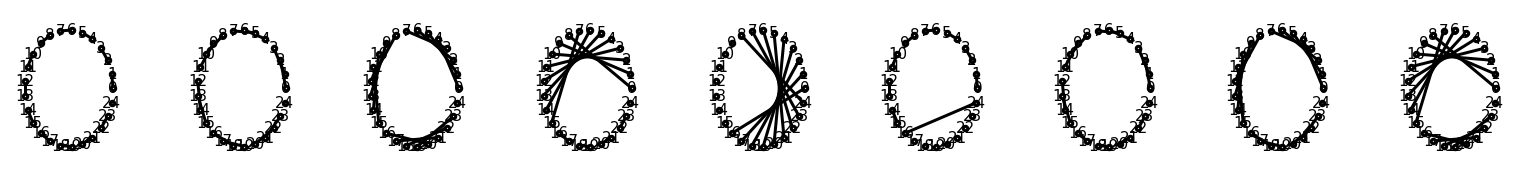

In [104]:
g = OnePeerDecoGraph11(25)
visualize(g, node_size=20, edge_label=False)

100%|██████████| 499/499 [02:00<00:00,  4.14it/s]


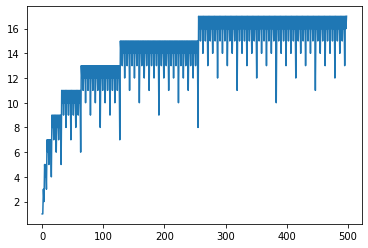

In [100]:
length_list = []

for n_nodes in tqdm(range(1, 500)):
    g = OnePeerDecoGraph11(n_nodes)
    length_list.append(len(g.w_list))
plt.plot(length_list)

In [101]:
init_w = torch.eye(g.n_nodes)

for w in g.w_list:
    init_w = init_w.matmul(w)
print(init_w)

tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]])
